In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from pytrends.request import TrendReq

# lookup table

In [2]:
lookup = [
    ['N', 'S', 'SS','S', 'N'],
    ['B', 'N', 'S', 'SS','S'],
    ['SB','B', 'N', 'S', 'SS'],
    ['B', 'SB','B', 'N', 'S'],
    ['N', 'B', 'SB','B', 'N']
]
lookup = pd.DataFrame(lookup, index=[5,4,3,2,1], columns=[5,4,3,2,1])
lookup.index.name = 'gtrend'
lookup.columns.name = 'p'; lookup

p,5,4,3,2,1
gtrend,,,,,
5,N,S,SS,S,N
4,B,N,S,SS,S
3,SB,B,N,S,SS
2,B,SB,B,N,S
1,N,B,SB,B,N


In [130]:
def get_gtrend(search, asof, nweeks=52*5):
    gtrend_from = pd.Timestamp(asof) - pd.Timedelta(weeks=nweeks)
    timeframe = str(gtrend_from.date()) + ' ' + asof #today 5-y'
    pytrends = TrendReq()
    pytrends.build_payload(search, timeframe=timeframe)
    resp = pytrends.interest_over_time()
    gtrend = resp[search].sum(axis=1)
    gtrend.index = gtrend.index.shift(7, freq='D')
    return gtrend


def get_p(symbol, gtrend):
    _start = gtrend.index[0] - pd.Timedelta(weeks=1)
    _end = gtrend.index[-1] + pd.Timedelta(weeks=1)
    p = yf.download([symbol], start=_start, end=_end, thread=True)['Adj Close']
    return p.reindex(gtrend.index, method='ffill')

  
def get_signal3(s):
    def evaluate(x):
        if x['52wh']:
            return 5

        elif 0 < x['4w'] < x['8w'] < x['12w']:
            return 4

        elif x['52wl']:
            return 1

        elif 0 > x['4w'] > x['8w'] > x['12w']:
            return 2

        else:
            return 3
    
    status = pd.DataFrame()
    status['4w'] = s.pct_change(4)
    status['8w'] = s.pct_change(8)
    status['12w'] = s.pct_change(12)
    status['52wh'] = (s.rolling(52, min_periods=52).max() == s)
    status['52wl'] = (s.rolling(52, min_periods=52).min() == s)
    status = status.iloc[51:]
    
    return status.apply(evaluate, axis=1)
    
    
def get_signal2(s):
    def evaluate(x):
        if x['52wh']:
            return 5

        elif 0 < x['4w'] < x['13w'] < x['26w']:
            return 4

        elif x['52wl']:
            return 1

        elif 0 > x['4w'] > x['13w'] > x['26w']:
            return 2

        else:
            return 3
    
    status = pd.DataFrame()
    status['4w'] = s.pct_change(4)
    status['13w'] = s.pct_change(13)
    status['26w'] = s.pct_change(26)
    status['52wh'] = (s.rolling(52, min_periods=52).max() == s)
    status['52wl'] = (s.rolling(52, min_periods=52).min() == s)
    status = status.iloc[51:]
    
    return status.apply(evaluate, axis=1)


def get_signal(s):
    def evaluate(x):
        if x['52wh']:
            return 5

        elif 0 < x['1w'] < x['4w'] < x['13w']:
            return 4

        elif x['52wl']:
            return 1

        elif 0 > x['1w'] > x['4w'] > x['13w']:
            return 2

        else:
            return 3
    
    status = pd.DataFrame()
    status['1w'] = s.pct_change(1)
    status['4w'] = s.pct_change(4)
    status['13w'] = s.pct_change(13)
    status['52wh'] = (s.rolling(52, min_periods=52).max() == s)
    status['52wl'] = (s.rolling(52, min_periods=52).min() == s)
    status = status.iloc[51:]
    
    return status.apply(evaluate, axis=1)


def plot_p_gtrend(p, gtrend, nback=52):
    p.iloc[-nback:].plot(label='p', legend=True)
    gtrend.iloc[-nback:].plot(secondary_y=True, label='gtrend', legend=True)

    
def plot_buysell(buysell, p, nback=52):
    f, ax = plt.subplots(figsize=(8,5))
    p.iloc[-nback:].plot(color='w', lw=3, ax=ax)
    sigs = buysell.iloc[-nback:].map({'SS':-2, 'S':-1, 'N':0, 'B':1, 'SB':2})
    c = ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), sigs.values[np.newaxis], cmap='coolwarm', alpha=1)
    c.set_clim(-2, 2)
    cbar = f.colorbar(c, ticks=[-2,-1,0,1,2])
    cbar.ax.set_yticklabels(['SS','S','N','B','SB']);
    
    
def plot_perf(buysell, p, nback=52, strat={'SS':-1, 'S':-0.5, 'N':0, 'B':0.5, 'SB':1}):
    perf = (buysell.shift(1).map(strat)*p.pct_change()).fillna(0)
    perf = perf.iloc[-nback:]
    perf.iloc[0] = 0
    #(perf + 1).cumprod().plot(label='perf', legend=True)
    #(p.iloc[-nback:] / p.iloc[-nback]).plot(label='p', legend=True)
    sim = simul(buysell, p, strat)
    sim_nav = sim.wealth
    #(sim.iloc[-nback:] / sim.iloc[-nback]).plot(label='sim', legend=True)
    
    df = pd.DataFrame()
    df['perf'] = (perf + 1).cumprod()
    df['p'] = (p.iloc[-nback:] / p.iloc[-nback])
    df['simul'] = (sim_nav.iloc[-nback:] / sim_nav.iloc[-nback])
    df.plot()
    return df, sim

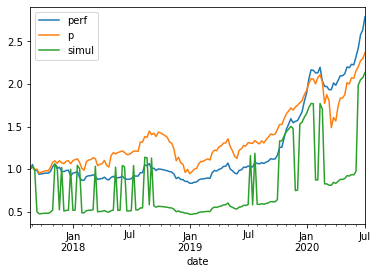

In [131]:
df, sim = plot_perf(buysell, p, nback=150, strat={'SS':0, 'S':0.25, 'N':0.5, 'B':1, 'SB':2})

In [132]:
df

,perf,p,simul
date,,,
2017-08-27,1.000000,1.000000,1.000000
2017-09-03,1.052421,1.026210,1.026210
2017-09-10,0.982880,0.992306,0.992306
2017-09-17,0.986752,1.000125,0.498108
2017-09-24,0.937439,0.950144,0.473215
...,...,...,...
2020-06-07,2.319878,2.155034,0.971947
2020-06-14,2.422050,2.202490,1.986700
2020-06-21,2.578183,2.273479,2.050734


In [133]:
sim.iloc[-150:]

,buysell,sig_change,p,hold,hold_lev,cash,nav,wealth
date,,,,,,,,
2017-08-27,2.0,False,153.825897,0.010019,0.010019,0.000000,1.541128,3.082257
2017-09-03,2.0,False,157.857742,0.010019,0.010019,0.000000,1.581522,3.163044
2017-09-10,0.5,True,152.642319,0.005009,0.000000,0.764635,1.529271,3.058541
2017-09-17,1.0,True,153.845123,0.009979,0.000000,0.000000,1.535296,1.535296
2017-09-24,0.5,True,146.156723,0.004990,0.000000,0.729285,1.458569,1.458569
...,...,...,...,...,...,...,...,...
2020-06-07,2.0,True,331.500000,0.009037,0.009037,0.000000,2.995790,2.995790
2020-06-14,2.0,False,338.799988,0.009037,0.009037,0.000000,3.061760,6.123520
2020-06-21,2.0,False,349.720001,0.009037,0.009037,0.000000,3.160445,6.320890


In [126]:
152.642319*0.010019

1.5293233940609998

In [112]:
buysell.iloc[-150:]

date
2017-08-27    SB
2017-09-03    SB
2017-09-10     N
2017-09-17     B
2017-09-24     N
              ..
2020-06-07    SB
2020-06-14    SB
2020-06-21    SB
2020-06-28    SB
2020-07-05    SB
Freq: W-SUN, Length: 150, dtype: object

In [127]:
def simul(buysell, p, strat):
    df = pd.DataFrame()
    df['buysell'] = buysell.map(strat)
    df['sig_change'] = (buysell != buysell.shift(1))
    df['p'] = p
    
    hold = []
    lev = []
    cash = []
    nav = []

    for record in df.itertuples():
        try:
            _hold_prev = hold[-1]
            _cash_prev = cash[-1]
            _nav = (record.p * _hold_prev) + _cash_prev

        except:
            _nav = 1

        if True:#record.sig_change:
            _cash = _nav * (1 - min(1,record.buysell))
            _lev = _nav * (max(1,record.buysell) - 1)
            _hold = (_nav - _cash) / record.p
            _hold_lev = _lev / record.p

        else:
            _cash = _cash_prev
            _hold = _hold_prev
            _hold_lev = hold_lev_prev

        hold.append(_hold)
        hold_lev.append(_hold_lev)
        cash.append(_cash)
        nav.append(_nav)

    df['hold'] = hold
    df['hold_lev'] = hold_lev
    df['cash'] = cash
    df['nav'] = nav
    return df

# 전역변수 설정

In [4]:
asof = '2020-06-29'
nweeks = 52*5

# 데이터 쿼리

In [81]:
gtrend = get_gtrend(['AAPL'], asof=asof, nweeks=nweeks)
p = get_p('AAPL', gtrend)

[*********************100%***********************]  1 of 1 completed


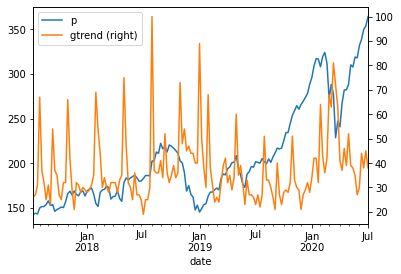

In [82]:
plot_p_gtrend(p, gtrend, nback=52*3)

# 시그널 만들기

In [83]:
signal = pd.DataFrame()
signal['p'] = get_signal(p)
signal['gtrend'] = get_signal(gtrend); signal

,p,gtrend
date,,
2016-07-10,3,3
2016-07-17,3,3
2016-07-24,3,3
2016-07-31,4,3
2016-08-07,4,3
...,...,...
2020-06-07,5,3
2020-06-14,5,3
2020-06-21,5,3


In [84]:
buysell = signal.apply(lambda x: lookup.at[x.gtrend, x.p], axis=1); buysell

date
2016-07-10     N
2016-07-17     N
2016-07-24     N
2016-07-31     B
2016-08-07     B
              ..
2020-06-07    SB
2020-06-14    SB
2020-06-21    SB
2020-06-28    SB
2020-07-05    SB
Freq: W-SUN, Length: 209, dtype: object

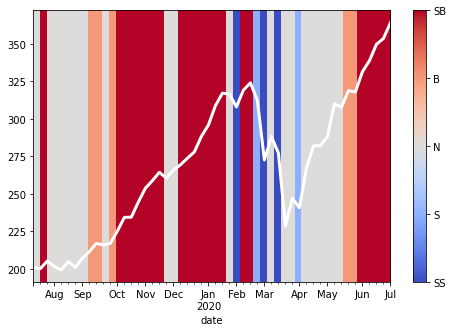

In [85]:
plot_buysell(buysell, p, nback=52)

# 시그널의 유효성

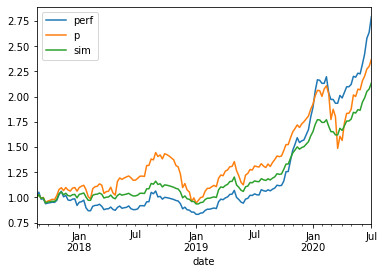

In [86]:
plot_perf(buysell, p, nback=150, strat={'SS':0, 'S':0.25, 'N':0.5, 'B':1, 'SB':2})

# 이슈

* 시그널 성과가 최소한 우상향 해야되지 않나?
* 구글트렌드 데이터 문제
    * 검색기간이 90일을 넘어가면 주간데이터로 자동변환
    * 이번주 데이터가 언제 나오는지 불확실: 6월 29일(월) 현재, 지난주 데이터만 출력되고 있음
* 구글트렌드는 stationary 한데... 52wh, 52wl 를 가격데이터와 비슷하게 취급하는게 맞나?

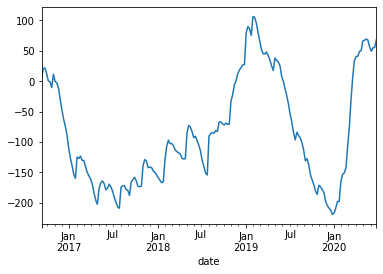

In [121]:
((gtrend - gtrend.rolling(52).mean())).iloc[60:].cumsum().plot()

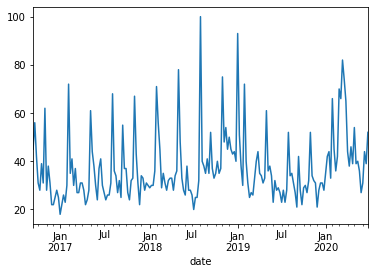

In [120]:
gtrend.iloc[60:].plot()